In [1]:
!nvidia-smi

Wed Aug 26 14:36:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 24%   23C    P8     7W / 180W |   7751MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 24%   28C    P8    12W / 180W |   7751MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [3]:
import numpy as np
from functools import partial
import tensorflow as tf
import scipy

from scipy.io import loadmat
from keras.layers import Input

from vdae.networks import VDAE, SpectralNet
from vdae.vdae_util import *

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

# DATASET

In [4]:
dataset = 'loop'

if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
    bsize = 512
elif dataset == 'coil20hr':
    d_in = scipy.io.loadmat('data/COIL20_UNPROC_128.mat')
    X = d_in['X'] / np.max(d_in['X'])
    Y = d_in['Y']-1
    Y = Y.reshape(-1)
    x_train, x_test = X.reshape((len(X), -1)), X.reshape((len(X), -1))
    y_train, y_test = Y, Y
    latent_dim = 10
    bsize = 256
elif dataset == 'bulldog':
    (x_train, y_train), (x_test, y_test) = generate_bulldog()
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 5
    bsize = len(x_train)

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset and 'cifar' not in dataset and 'bulldog' not in dataset and 'gaussian_grid' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b

arch = [
    {'type': 'relu', 'size': 500},
    {'type': 'linear', 'size': latent_dim},
    ]

# TRAIN SPECTRALNET

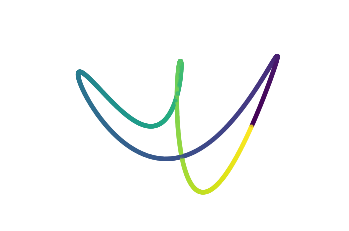

In [5]:
g = plot(x_train, y_train)

In [6]:
n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }

In [7]:
spectral_net = SpectralNet(inputs=inputs, arch=arch,
                spec_reg=None, y_true=y_true, y_train_labeled_onehot=y_train_labeled_onehot,
                n_clusters=n_clusters, affinity='full', scale_nbr=3, n_nbrs=12, 
                batch_sizes=batch_sizes, siamese_net=None, 
                x_train=x_train, have_labeled=False)

In [8]:
spectral_net.train(
            x_train, np.zeros_like(x_train[0:0]), x_test,
            lr=1e-5, drop=0.1, patience=20, num_epochs=200)

Epoch: 0, val_loss=0.000000
Epoch: 0, loss=0.005256, val_loss=0.000002
Epoch: 1, loss=0.005031, val_loss=0.000002
Epoch: 2, loss=0.003298, val_loss=0.000001
Epoch: 3, loss=0.002139, val_loss=0.000001
Epoch: 4, loss=0.001652, val_loss=0.000001
Epoch: 5, loss=0.001399, val_loss=0.000000
Epoch: 6, loss=0.001242, val_loss=0.000000
Epoch: 7, loss=0.001136, val_loss=0.000000
Epoch: 8, loss=0.001062, val_loss=0.000000
Epoch: 9, loss=0.001006, val_loss=0.000000
Epoch: 10, loss=0.000962, val_loss=0.000000
Epoch: 11, loss=0.000925, val_loss=0.000000
Epoch: 12, loss=0.000895, val_loss=0.000000
Epoch: 13, loss=0.000870, val_loss=0.000000
Epoch: 14, loss=0.000849, val_loss=0.000000
Epoch: 15, loss=0.000831, val_loss=0.000000
Epoch: 16, loss=0.000815, val_loss=0.000000
Epoch: 17, loss=0.000800, val_loss=0.000000
Epoch: 18, loss=0.000788, val_loss=0.000000
Epoch: 19, loss=0.000776, val_loss=0.000000
Epoch: 20, loss=0.000766, val_loss=0.000000
Epoch: 21, loss=0.000757, val_loss=0.000000
Epoch: 22, los

(array([0.00525608, 0.00503084, 0.00329772, 0.00213881, 0.00165248,
        0.00139852, 0.00124167, 0.00113649, 0.00106193, 0.001006  ,
        0.00096172, 0.00092531, 0.00089459, 0.00086951, 0.00084871,
        0.00083095, 0.00081491, 0.0008003 , 0.00078759, 0.00077627,
        0.00076608, 0.00075686, 0.00074843, 0.00074092, 0.00073418,
        0.00072779, 0.00072141, 0.00071554, 0.00071003, 0.00070453,
        0.00069917, 0.00069401, 0.00068919, 0.00068491, 0.00068113,
        0.00067736, 0.00067378, 0.0006704 , 0.00066719, 0.00066413,
        0.00066113, 0.00065828, 0.00065558, 0.0006529 , 0.00065043,
        0.00064812, 0.00064583, 0.00064356, 0.00064139, 0.00063916,
        0.00063708, 0.0006351 , 0.00063313, 0.00063133, 0.0006296 ,
        0.00062794, 0.00062629, 0.00062456, 0.00062272, 0.00062099,
        0.00061951, 0.00061817, 0.00061684, 0.00061543, 0.00061395,
        0.00061255, 0.00061121, 0.00060989, 0.00060911, 0.00060897,
        0.00060883, 0.0006087 , 0.00060856, 0.00

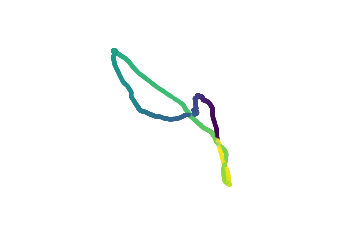

In [9]:
y_pred = spectral_net.predict(x_train)
g = plot(y_pred[:,:3], y_train.reshape(-1,))

In [10]:
# plot images over embeddings
if 'mnist' in dataset or 'cifar' in dataset or 'coil' in dataset or 'faces' in dataset:
    zoom = 1
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    elif 'coil' in dataset and 'hr' in dataset:
        img_shape = (128, 128)
        zoom = 0.2
    elif 'coil' in dataset:
        img_shape = (32, 32)
    elif 'faces' in dataset:
        img_shape = (28, 20)
        zoom = 2
    _ = imscatter(y_pred[p,0], y_pred[p,1], x_train[p], shape=img_shape, zoom=zoom)

# TRAIN VDAE

In [15]:
arch

[{'size': 500, 'type': 'relu'}, {'size': 3, 'type': 'linear'}]

In [11]:
svg_bsize = 288
svg_k = 2
svg_arch = [500]

svg = VDAE(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[1:], k=svg_k, alpha=1., arch=svg_arch)

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

In [ ]:
svg.train(x_train, epochs=5000, batch_size=svg_bsize, full_batch=True)

In [ ]:
# take a random walk step of a point. then plot its nearest neighbor
x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_train, return_mu_sigma=True, normalize_cov=False)

In [ ]:
plot(x_recon[:1000], y_train[:1000])

# ANALYSIS

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)#, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
    orig_shape = (-1,) + (x_arr.shape[1:])
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape(orig_shape)
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:max_size]
        x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p], _x_enc[p]
        x_arr = x_arr.reshape(orig_shape)
    
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc

# NOW GENERATE all data points
max_size = min(1000, len(x_train))
x_arrs = []
test_size = len(x_train)
n_ = 0
while n_ < test_size:
    p = np.random.permutation(len(x_test))[:200]
    x_test_sample = x_test[p]
    x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=4, branch_factor=2, max_size=max_size)
    x_arrs.append(x_arr)
    n_ += len(x_arr)
    print("generated {}/{} points".format(n_, test_size), _x_enc.shape, x_arr.shape)

x_gens = np.concatenate(x_arrs, axis=0)[:len(x_train)]

# COMPUTE GROMOV-WASSERSTEIN
gw = gromorov_wasserstein_d(x_train, x_gens)

# COMPUTE BILIP CONSTANT
Ks = bilip(_x_enc, x_arr, 100)
print('Mean bi-Lipschitz constant: {:.4f} +- {:.4f}'.format(np.mean(Ks), np.std(Ks)))
print('Gromov-wasserstein distance: {:.4f}'.format(gw))

In [ ]:
# pick subset size
n_p = min(1000, len(x_train))
p = np.random.permutation(len(x_train))[:n_p]
x_train_p = x_train[p]
y_train_p = y_train[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train_p, normalize_cov=False)
g = plot(x_gen, y_train_p, x2=x_train_p, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]

### RANDOM WALK TESTING

In [ ]:
p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=10)

In [ ]:
p = np.random.permutation(len(x_arr))
x_true_n_gen = np.concatenate([x_test_sample, x_arr[p]], axis=0)
g = plot(x_true_n_gen, shuffle=False)

In [ ]:
g, ax = plot(x_arr, x2=x_test, label1='predicted', label2='true', alpha2=0.2)
plt.title('predicted vs true points in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test)[1], label1='predicted', label2='true')
plt.title('predicted vs true points in latent space')

In [ ]:
g = plot(x_arr, x2=x_test_sample, label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test_sample)[1], label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in latent space')